<a href="https://www.kaggle.com/jaganadhg/atomicai-starter?scriptVersionId=88610688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
The challenge 'Collision detection AI competition using vibration data' is hosted by the Korea Atomic Energy Research Institute.  The objective is to predict collider parameters using time and acceleration data. 

A collider is a type of particle accelerator that brings two opposing particle beams together such that the particles collide [Wikipedia]. The colliders inside the coolant systems inside a nuclear power plant. Detecting any abnormal activity in the collider helps technicians to prevent accidents.  Details of the competitions are available at https://dacon.io/competitions/official/235614/overview/. 

In [1]:
%matplotlib inline
import os
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn as sl
import scipy as sp

from tqdm import tqdm

In [2]:
train_data = pd.read_csv("/kaggle/input/collision-detection-ai-using-vibration-data/train_features.csv")
train_target = pd.read_csv("/kaggle/input/collision-detection-ai-using-vibration-data/train_target.csv")
test_data = pd.read_csv("/kaggle/input/collision-detection-ai-using-vibration-data/test_features.csv")

In [3]:
submission_file = pd.read_csv("/kaggle/input/collision-detection-ai-using-vibration-data/sample_submission.csv")

In [4]:
train_data.shape,train_target.shape

((1050000, 6), (2800, 5))

In [5]:
train_data.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [6]:
train_target.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB


In [8]:
train_data.id.nunique()

2800

In [9]:
train_data[train_data.id == 0]

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.00,0.00,0.000
1,0,0.000004,0.00,0.00,0.00,0.000
2,0,0.000008,0.00,0.00,0.00,0.000
3,0,0.000012,0.00,0.00,0.00,0.000
4,0,0.000016,0.00,0.00,0.00,0.000
...,...,...,...,...,...,...
370,0,0.001480,-64168.90,-64168.90,52279.59,106792.600
371,0,0.001484,-64236.79,-64236.79,16518.64,58248.420
372,0,0.001488,-63755.95,-63755.95,-25270.30,3015.649
373,0,0.001492,-63020.44,-63020.44,-65904.66,-49795.140


In [10]:
train_data[train_data.id == 1]

,id,Time,S1,S2,S3,S4
375,1,0.000000,0.0,0.0,0.00,0.00
376,1,0.000004,0.0,0.0,0.00,0.00
377,1,0.000008,0.0,0.0,0.00,0.00
378,1,0.000012,0.0,0.0,0.00,0.00
379,1,0.000016,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...
745,1,0.001480,962514.8,318184.5,396361.80,-641504.60
746,1,0.001484,1031978.0,354831.0,248709.80,-528058.80
747,1,0.001488,1069688.0,354107.2,93556.34,-394603.00
748,1,0.001492,1068054.0,310828.9,-42801.14,-246912.00


# Data

The train data contains five attributes. The attribute id and time are self-explanatory. The acceleration parameters in the collider are labeled as S1, S2, S3, and S4. In this data, each id is corresponding to one training instance. The timestamp difference between each observation in id is four seconds, and it can be considered an equispaced time series data-set. For each id, there is a corresponding entry in the training targets data. There are 1050000 in the training data and 2800 entries. The training target contains 2800 entries for X, Y, M, and V. These are the prediction target, the collider parameters. 


Unlike the traditional data-sets in Machine learning exercises, we can't jump into modeling immediately. The data should be further converted to an appropriate scientific format before approaching the problem. One of the widely adopted methods is to apply Fourier Transform before using any modeling techniques. Let's explore the data further to understand the same. 

## EDA


In [11]:
def plot_data(accelaration_df : pd.DataFrame,features : list, title : str) -> None:
    """ Plot the accelaration data
        :params accelaration_df: accelaration data for one id
        :params title: string
    """
    
    fig = plt.figure(figsize=(10,6))
    fig.tight_layout(pad=10.0)
    fig.suptitle(title)
    
    for idx,feature in enumerate(features):
        ax = fig.add_subplot(2,2,idx+1)
        accelaration_df[feature].plot(kind='line',
                                     title = title + " " + feature,
                                     ax=ax)

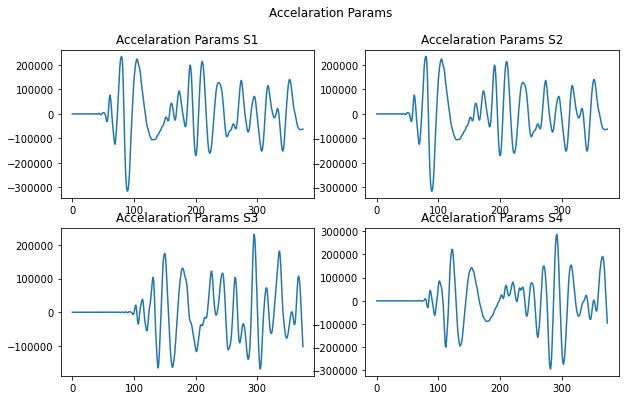

In [12]:
feats_to_plot = ["S1","S2","S3", "S4"]
plot_data(train_data[train_data.id == 0],feats_to_plot,"Accelaration Params")

In [13]:
train_target[train_target.id == 0]

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4


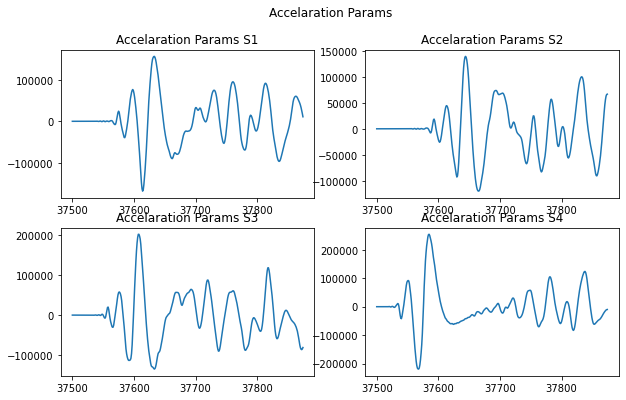

In [14]:
feats_to_plot = ["S1","S2","S3", "S4"]
plot_data(train_data[train_data.id == 100],feats_to_plot,"Accelaration Params")

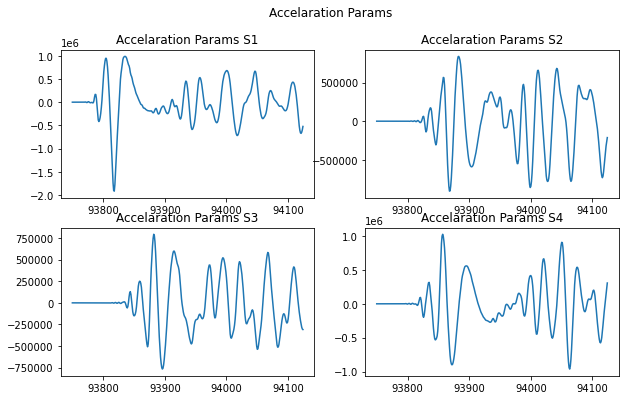

In [15]:
feats_to_plot = ["S1","S2","S3", "S4"]
plot_data(train_data[train_data.id == 250],feats_to_plot,"Accelaration Params")

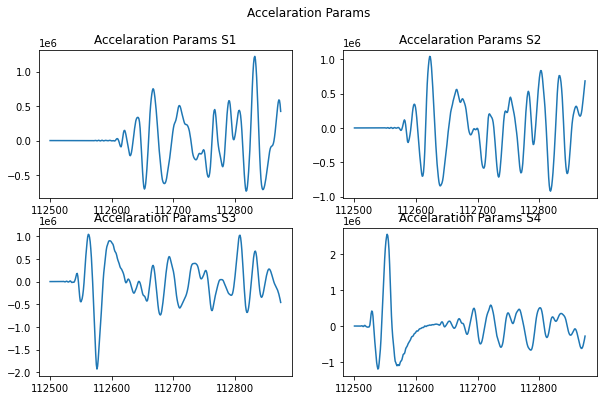

In [16]:
feats_to_plot = ["S1","S2","S3", "S4"]
plot_data(train_data[train_data.id == 300],feats_to_plot,"Accelaration Params")

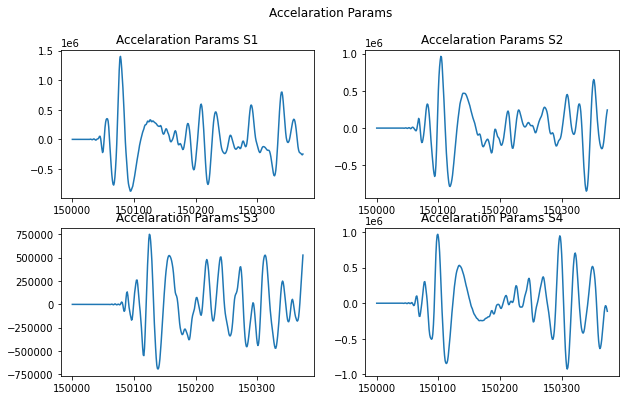

In [17]:
feats_to_plot = ["S1","S2","S3", "S4"]
plot_data(train_data[train_data.id == 400],feats_to_plot,"Accelaration Params")

## Fourier Transform 

One of the prominent methods to approach signal data is to apply forurier transformation in the data. The Fourier transformed data can be used for training a model. 

In [18]:
fs = 5 #sampling frequency
fmax = 25 #sampling period
dt = 1/fs #length of signal
n = 75

def fft_features(data_set : pd.DataFrame) -> np.ndarray:
    """ Convert the dataset to fourier transfomed
        :params data_set: original collider params data
        :returns ft_data: Fourier transformed data
        #Reference - https://dacon.io/competitions/official/235614/codeshare/1174
    """
    ft_data = list()
    
    features = ["S1","S2","S3", "S4"]
    
    id_set = list(data_set.id.unique())
    
    for ids in tqdm(id_set):
        s1_fft = np.fft.fft(data_set[data_set.id==ids]['S1'].values)*dt
        s2_fft = np.fft.fft(data_set[data_set.id==ids]['S2'].values)*dt
        s3_fft = np.fft.fft(data_set[data_set.id==ids]['S3'].values)*dt
        s4_fft = np.fft.fft(data_set[data_set.id==ids]['S4'].values)*dt
        
        ft_data.append(np.concatenate([np.abs(s1_fft[0:int(n/2+1)]),
                                       np.abs(s2_fft[0:int(n/2+1)]),
                                       np.abs(s3_fft[0:int(n/2+1)]),
                                       np.abs(s4_fft[0:int(n/2+1)])]))
    
    return np.array(ft_data)

In [19]:
train_fft = fft_features(train_data)

100%|██████████| 2800/2800 [00:21<00:00, 133.29it/s]


In [20]:
train_fft.shape[0] == len(train_data.id.unique())

True

In [21]:
test_fft = fft_features(test_data)

100%|██████████| 700/700 [00:02<00:00, 266.62it/s]


In [22]:
test_fft.shape[0] == len(test_data.id.unique())

True

# Model
Let's create a multi-output Regressor Model.

In [23]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
base_model = GradientBoostingRegressor(loss='quantile',
                                      n_estimators=100,
                                      criterion='mae',
                                      random_state=2021,
                                      max_features='sqrt',
                                      n_iter_no_change=2)

mult_regressor = MultiOutputRegressor(base_model,
                                      n_jobs=-1)

In [25]:
mult_regressor.fit(train_fft,
                  train_target.drop(['id'],axis=1))

MultiOutputRegressor(estimator=GradientBoostingRegressor(criterion='mae',
                                                         loss='quantile',
                                                         max_features='sqrt',
                                                         n_iter_no_change=2,
                                                         random_state=2021),
                     n_jobs=-1)

In [26]:
predictions = mult_regressor.predict(test_fft)

In [27]:
predictions[0]

array([400., 400., 175.,   1.])

In [28]:
submission_file[['X','Y','M','V']] = predictions
submission_file.head()

,id,X,Y,M,V
0,2800,400.0,400.0,175.0,1.0
1,2801,400.0,400.0,175.0,1.0
2,2802,400.0,400.0,175.0,1.0
3,2803,400.0,400.0,175.0,1.0
4,2804,400.0,400.0,175.0,1.0


In [29]:
submission_file.to_csv("submission_1_1.csv",
                  index=False)

# Result
The submission ranked - 13.48313 (score) 226 in Public leaderbord.

# Alternative Fature Engineering
An alternative approach in feature engineering is to aggregate the features and compute key statistics such as mean, median, standard deviation, minimum value, and skew. 

In [30]:
def generate_agg_feats(data_set : pd.DataFrame) -> pd.DataFrame:
    """ Create aggrage features from the data
        :param data_set: Base data as DataFrame
        :returns agg_data: Aggragated DataFrame
    """
    
    max_feats = data_set.groupby(['id']).max().add_suffix('_max').iloc[:,1:]
    min_feats = data_set.groupby(['id']).min().add_suffix('_min').iloc[:,1:]
    mean_feats = data_set.groupby(['id']).mean().add_suffix('_mean').iloc[:,1:]
    std_feats = data_set.groupby(['id']).std().add_suffix('_std').iloc[:,1:]
    median_feats = data_set.groupby(['id']).median().add_suffix('_median').iloc[:,1:]
    skew_feats = data_set.groupby(['id']).skew().add_suffix('_skew').iloc[:,1:]
    
    agg_data = pd.concat([max_feats,min_feats,
                          mean_feats,std_feats,median_feats,skew_feats],
                        axis=1)
    
    return agg_data

In [31]:
agg_train = generate_agg_feats(train_data)
agg_train.shape

(2800, 24)

In [32]:
agg_train.head()

,S1_max,S2_max,S3_max,S4_max,S1_min,S2_min,S3_min,S4_min,S1_mean,S2_mean,...,S3_std,S4_std,S1_median,S2_median,S3_median,S4_median,S1_skew,S2_skew,S3_skew,S4_skew
id,,,,,,,,,,,,,,,,,,,,,
0,235080.9,235080.9,231773.4,286557.2,-315471.5,-315471.5,-168789.1,-293865.7,-308.304553,-308.304553,...,73381.881823,93657.794500,-17.249630,-17.24963,0.000000e+00,0.008652,-0.000219,-0.000219,0.299376,-0.212332
1,1069688.0,1244737.0,951349.6,1095499.0,-826482.9,-2390317.0,-1137225.0,-1306526.0,12780.176893,981.778780,...,393470.633500,468914.485995,0.000000,-1090.97900,1.053139e-06,0.000000,0.521826,-0.701078,-0.088361,0.018837
2,383092.2,150770.4,148724.0,168649.2,-364591.8,-161006.0,-150458.2,-201313.7,-674.289628,-1575.681938,...,53274.867908,64025.270683,-8063.518000,0.00000,0.000000e+00,0.000000,0.516960,-0.087335,0.160090,-0.100796
3,379650.3,378475.3,394448.7,487880.4,-329680.7,-726961.0,-333712.8,-463918.9,2164.216981,-11274.728589,...,144260.409981,143137.423122,0.000118,-10742.91000,5.255491e-07,21.546210,-0.055517,-0.475508,-0.089726,0.113817
4,754833.0,321731.2,373526.8,397334.0,-592148.9,-378091.6,-423593.5,-472361.4,-980.480585,-6966.912566,...,150043.470527,131857.519354,-19297.320000,0.00000,1.173251e-05,1384.087000,0.826098,-0.107505,-0.157477,-0.216489


In [33]:
agg_test = generate_agg_feats(test_data)
agg_test.shape

(700, 24)

# Model Two with Aggragted Data

In [34]:
mult_regressor.fit(agg_train,
                  train_target.drop(['id'],axis=1))

MultiOutputRegressor(estimator=GradientBoostingRegressor(criterion='mae',
                                                         loss='quantile',
                                                         max_features='sqrt',
                                                         n_iter_no_change=2,
                                                         random_state=2021),
                     n_jobs=-1)

In [35]:
agg_pred = mult_regressor.predict(agg_test)

In [36]:
agg_pred[0]

array([400., 400., 175.,   1.])

In [37]:
submission_file[['X','Y','M','V']] = agg_pred
submission_file.head()

,id,X,Y,M,V
0,2800,400.0,400.0,175.0,1.0
1,2801,400.0,400.0,175.0,1.0
2,2802,400.0,400.0,175.0,1.0
3,2803,400.0,400.0,175.0,1.0
4,2804,400.0,400.0,175.0,1.0


In [38]:
submission_file.to_csv("submission_2.csv",
                  index=False)

#### Score
In this case also the score is same (13.48313). We need to try alternative modelling approach to make it better.

# Support Vector Regressor

In [39]:
from sklearn.svm import SVR
from sklearn.multioutput import RegressorChain

In [40]:
svr = SVR(kernel='rbf',
         gamma='auto',
         shrinking=True)
regressor_chain = RegressorChain(svr,
                                order='random',
                                random_state=1999)

In [41]:
regressor_chain.fit(agg_train,
                  train_target.drop(['id'],axis=1))

RegressorChain(base_estimator=SVR(gamma='auto'), order='random',
               random_state=1999)

In [42]:
svr_p1 = regressor_chain.predict(agg_test)

In [43]:
submission_file[['X','Y','M','V']] = svr_p1
submission_file.head()

,id,X,Y,M,V
0,2800,0.0,-0.211111,100.0,0.6
1,2801,0.0,-0.211111,100.0,0.6
2,2802,0.0,-0.211111,100.0,0.6
3,2803,0.0,-0.211111,100.0,0.6
4,2804,0.0,-0.211111,100.0,0.6


In [44]:
submission_file.to_csv("submission_3.csv",
                  index=False)

## Improved
Our score went to 3.25082 in LB!!

In [45]:
regressor_chain.fit(train_fft,
                  train_target.drop(['id'],axis=1))

RegressorChain(base_estimator=SVR(gamma='auto'), order='random',
               random_state=1999)

In [46]:
fft_pred = regressor_chain.predict(test_fft)

In [47]:
submission_file[['X','Y','M','V']] = fft_pred
submission_file.head()

,id,X,Y,M,V
0,2800,0.0,-0.211111,100.0,0.6
1,2801,0.0,-0.211111,100.0,0.6
2,2802,0.0,-0.211111,100.0,0.6
3,2803,0.0,-0.211111,100.0,0.6
4,2804,0.0,-0.211111,100.0,0.6


In [48]:
submission_file.to_csv("submission_4.csv",
                  index=False)

### Submission
Submission with FFT and aggragated features resulted in the same LB score.
